In [1]:
import simpy
import random
import matplotlib.pyplot as plt

# With recording waiting times

In [123]:
class M_M_n_queue:
    def __init__(self, env, arrival_rate, service_rate, num_servers):
        self.env = env
        self.server = simpy.Resource(env, num_servers)
        self.arrival_rate = arrival_rate
        self.service_rate = service_rate
        self.waiting_time_in_the_queue=[]
        self.queue = []
        

    def arrival(self, sjf = False):
        """The arrival process generates customers according to a Poisson process"""
        customer = 0
        while True:
            ### Interarrival times follow exponential
            next_customer= random.expovariate(self.arrival_rate)
            ### Wait for the customer
            yield self.env.timeout(next_customer)  
            customer += 1
            
            ### Start a service process
            self.env.process(self.service(customer, sjf))

    def service(self, customer, sjf = False):
        """The service process. The customer arrives and requests a service. The service time follows 
           the exponential distribution"""
        if sjf == False:
            with self.server.request() as req:
                queue_arrival_time= self.env.now
                yield req
                #### calculate waiting time
                waiting_time = self.env.now - queue_arrival_time
                
                service_time = random.expovariate(self.service_rate)
                yield self.env.timeout(service_time)
                
                self.waiting_time_in_the_queue.append(waiting_time)
        else:
            with self.server.request() as req:
                queue_arrival_time = self.env.now
                yield req
                #### calculate waiting time
                waiting_time = self.env.now - queue_arrival_time
                
                service_time = random.expovariate(self.service_rate)
                #### add customer to the queue with service time and sort queue
                self.queue.append((customer, service_time))
                #print(service_time)
                #print(self.queue)
                self.queue.sort(key=lambda x: x[1])
                #print(self.queue)

                if self.queue[0][0] != customer:
                    #### wait until it's the current customer's turn based on SJF
                    yield self.env.timeout(0)

                yield self.env.timeout(service_time)
                self.waiting_time_in_the_queue.append(waiting_time)
                #### remove the customer that finished service
                self.queue.pop(0)

        
def setup(arrival_rate, service_rate, sim_time, num_servers, sjf = False):
    """Setup and start the simulation and returns average waiting time in one simulation"""
    env = simpy.Environment()
    M_M_n = M_M_n_queue(env, arrival_rate, service_rate, num_servers)
    env.process(M_M_n.arrival(sjf))
    env.run(until=sim_time)
    average_waiting_time = sum(M_M_n.waiting_time_in_the_queue) / len(M_M_n.waiting_time_in_the_queue)

    return average_waiting_time, len(M_M_n.waiting_time_in_the_queue)

def simulate(arrival_rate, service_rate, sim_time, num_simulations, num_servers, sjf = False):
    """Returns average waiting time over provided number of simulations"""
    average_waiting_time_list = []
    for i in range(num_simulations):
        average_waiting_time, N_customers = setup(arrival_rate, service_rate, sim_time, num_servers, sjf)
        average_waiting_time_list.append(average_waiting_time)
        
    average_waiting_time_over_simulations = sum(average_waiting_time_list) / num_simulations

    print(f' Average waiting time in the queue with number of servers ={num_servers} over {num_simulations} simulations: {average_waiting_time_over_simulations}')
    return average_waiting_time_over_simulations, N_customers



In [184]:
# Parameters 

arrival_rate = 5  #average time between arrivals is 0.2 minutes, or on average 5 people arrive every minute, so the rate=5
service_rate = 1/5   # average service time is 5 minutes, so the rate is 1/5 

simulation_time = 1000
num_simulations = 1
num_servers = 1

simulate(arrival_rate, service_rate, simulation_time, num_simulations, num_servers)



 Average waiting time in the queue with number of servers =1 over 100 simulations: 475.8561186515898


(475.8561186515898, 212)

# For different number of servers n

In [185]:
num_servers_list= [1, 2, 4]

for num_servers in num_servers_list:
    _, N_customers = simulate(arrival_rate, service_rate, simulation_time, num_simulations, num_servers)
    print(f'Customers: {N_customers} \n')


 Average waiting time in the queue with number of servers =1 over 100 simulations: 470.1529645520428
Customers: 202 

 Average waiting time in the queue with number of servers =2 over 100 simulations: 455.0830764994365
Customers: 386 

 Average waiting time in the queue with number of servers =4 over 100 simulations: 414.3588274439428
Customers: 836 



In [188]:
import numpy as np

def test_order_of_service(arrival_rate, service_rate, sim_time, num_servers):
    average_waiting_time, _ = setup(arrival_rate, service_rate, sim_time, num_servers, sjf=True)
    average_waiting_time_no_sjf, _ = setup(arrival_rate, service_rate, sim_time, num_servers, sjf=False)

    return average_waiting_time, average_waiting_time_no_sjf

grand_average_waiting = []
grand_average_waiting_no_sjf = [] 
for i in range(100):
    x, y = test_order_of_service(arrival_rate=0.5, service_rate=0.2, sim_time=100, num_servers=1)
    grand_average_waiting.append(x)
    grand_average_waiting_no_sjf.append(y)

grand_average_waiting = np.mean(grand_average_waiting)
grand_average_waiting_no_sjf = np.mean(grand_average_waiting_no_sjf)

print(grand_average_waiting, grand_average_waiting_no_sjf)

25.47661163819562 25.61753823088883


1000
1000


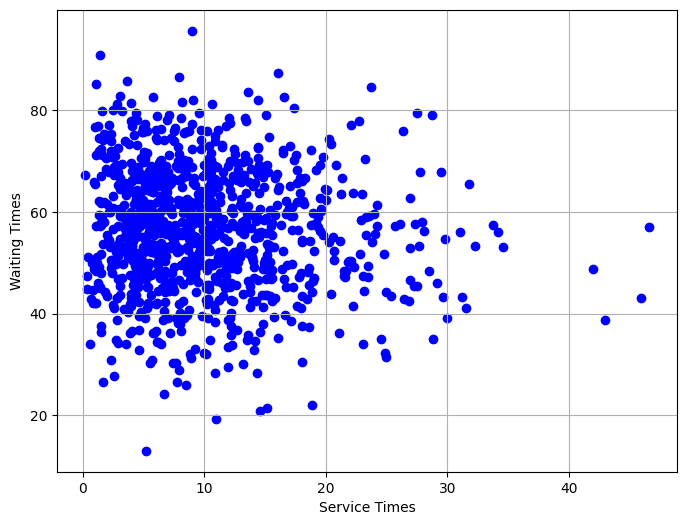

In [187]:
def plot_service_vs_waiting(arrival_rate, service_rate, sim_time, num_servers, num_simulations, sjf):
    waiting_times = []
    service_times = []

    for i in range(num_simulations):
        env = simpy.Environment()
        M_M_n = M_M_n_queue(env, arrival_rate, service_rate, num_servers)
        env.process(M_M_n.arrival(sjf=sjf))  # run simulation with SJF
        env.run(until=sim_time)

        # calculate and store waiting times
        average_waiting_time = sum(M_M_n.waiting_time_in_the_queue) / len(M_M_n.waiting_time_in_the_queue)
        waiting_times.append(average_waiting_time)

        # store service times for plotting
        service_times.extend([s[1] for s in M_M_n.queue])

    plt.figure(figsize=(8, 6))
    print(len(service_times))
    print(len(waiting_times))
    plt.scatter(service_times, waiting_times, marker='o', color='blue')
    plt.xlabel('Service Times')
    plt.ylabel('Waiting Times')
    plt.grid(True)
    plt.show()

# Test and plot service times vs waiting times
plot_service_vs_waiting(arrival_rate=0.5, service_rate=0.2, sim_time=200, num_servers=1, num_simulations=1000, sjf=True)
